<a href="https://colab.research.google.com/github/ymk-scsa/reversi_dqn2/blob/main/reversi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 必要なライブラリをインポート
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy

In [ ]:
class OthelloBoard:
    """
    オセロの盤面クラス
    1 = 黒石, -1 = 白石, 0 = 空
    8x8標準サイズ
    """
    def __init__(self, n=8):
        assert n % 2 == 0 and n >= 4
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        # 初期配置
        self.board[mid-1, mid-1] = -1
        self.board[mid, mid] = -1
        self.board[mid-1, mid] = 1
        self.board[mid, mid-1] = 1

    def copy(self):
        b = OthelloBoard(self.n)
        b.board = self.board.copy()
        return b

    def inside(self, r, c):
        return 0 <= r < self.n and 0 <= c < self.n

    def legal_moves(self, player):
        """指定したプレイヤーにとって合法な手のリストを返す"""
        dirs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        moves = set()
        opp = -player
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r,c] != 0:
                    continue
                for dr,dc in dirs:
                    rr, cc = r+dr, c+dc
                    found_opp = False
                    while self.inside(rr,cc) and self.board[rr,cc] == opp:
                        found_opp = True
                        rr += dr; cc += dc
                    if found_opp and self.inside(rr,cc) and self.board[rr,cc] == player:
                        moves.add((r,c))
                        break
        return list(moves)

    def apply_move(self, move, player):
        """指定した手を盤面に適用する"""
        if move is None:
            return
        r,c = move
        if not self.inside(r,c):
            raise ValueError("盤面の外に打とうとしています")
        if self.board[r,c] != 0:
            raise ValueError("そこには既に石があります")
        dirs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        self.board[r,c] = player
        opp = -player
        for dr,dc in dirs:
            rr, cc = r+dr, c+dc
            flips = []
            while self.inside(rr,cc) and self.board[rr,cc] == opp:
                flips.append((rr,cc))
                rr += dr; cc += dc
            if self.inside(rr,cc) and self.board[rr,cc] == player and flips:
                for fr,fc in flips:
                    self.board[fr,fc] = player

    def is_terminal(self):
        """両プレイヤーが合法手を持たない場合、終了とする"""
        return (len(self.legal_moves(1)) == 0) and (len(self.legal_moves(-1)) == 0)

    def score(self):
        """スコア: 黒石数 - 白石数"""
        return int(self.board.sum())

    def render(self):
        """盤面をテキストで表示する"""
        rows = []
        header = "   " + " ".join([str(i) for i in range(self.n)])
        rows.append(header)
        for r in range(self.n):
            s = f"{r:2d} "
            for c in range(self.n):
                v = self.board[r,c]
                if v == 1:
                    s += "● "
                elif v == -1:
                    s += "○ "
                else:
                    s += ". "
            rows.append(s)
        print("\n".join(rows))

In [ ]:
def random_playout(board: OthelloBoard, player: int):
    """両者がランダムに打ち合って終了まで進める"""
    b = board.copy()
    cur = player
    passes = 0
    while not b.is_terminal():
        moves = b.legal_moves(cur)
        if moves:
            mv = random.choice(moves)
            b.apply_move(mv, cur)
            passes = 0
        else:
            passes += 1
            if passes >= 2:
                break
        cur = -cur
    sc = b.score()
    if sc > 0: return 1
    elif sc < 0: return -1
    else: return 0


def play_game(agent_black, agent_white, verbose=False):
    """2つのエージェントを対戦させる"""
    b = OthelloBoard()
    cur = 1  # 黒から開始
    agents = {1: agent_black, -1: agent_white}
    passes = 0
    while not b.is_terminal():
        agent = agents[cur]
        mv = agent(b, cur) if callable(agent) else agent.select(b, cur)
        if mv is None:
            passes += 1
            if passes >= 2:
                break
        else:
            passes = 0
            b.apply_move(mv, cur)
        cur = -cur
    sc = b.score()
    winner = 1 if sc > 0 else (-1 if sc < 0 else 0)
    if verbose:
        b.render()
        print("score:", sc, "winner:", winner)
    return winner, sc, b


def evaluate(agentA, agentB, n_games=10):
    """AとBを交互に先後入れ替えて複数対戦させる"""
    wins = {"A":0, "B":0, "draw":0}
    scores = []
    for i in range(n_games):
        if i % 2 == 0:
            a_black = agentA; a_white = agentB
        else:
            a_black = agentB; a_white = agentA
        w, sc, _ = play_game(a_black, a_white, verbose=False)
        if w == 0:
            wins["draw"] += 1
        elif (w == 1 and i%2==0) or (w == -1 and i%2==1):
            wins["A"] += 1
        else:
            wins["B"] += 1
        scores.append(sc)
    return wins, np.mean(scores), scores

In [ ]:
def random_agent(board: OthelloBoard, player: int):
    moves = board.legal_moves(player)
    if not moves:
        return None
    return random.choice(moves)


class FlatMonteCarloAgent:
    def __init__(self, sims_per_move=20):
        self.sims = sims_per_move

    def select(self, board: OthelloBoard, player: int):
        moves = board.legal_moves(player)
        if not moves:
            return None
        best = None
        best_rate = -1
        for mv in moves:
            wins = 0
            for _ in range(self.sims):
                b2 = board.copy()
                b2.apply_move(mv, player)
                winner = random_playout(b2, -player)
                if winner == player:
                    wins += 1
                elif winner == 0:
                    wins += 0.5
            rate = wins / self.sims
            if rate > best_rate:
                best_rate = rate
                best = mv
        return best


class MCTSNode:
    def __init__(self, board: OthelloBoard, parent=None, move=None, player_who_moved=None):
        self.board = board
        self.parent = parent
        self.move = move
        self.player = player_who_moved
        self.children = []
        self.untried_moves = None
        self.visits = 0
        self.wins = 0.0

    def is_fully_expanded(self, player_to_move):
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        return len(self.untried_moves) == 0

    def expand(self, player_to_move):
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        if not self.untried_moves:
            return None
        mv = self.untried_moves.pop(random.randrange(len(self.untried_moves)))
        new_board = self.board.copy()
        new_board.apply_move(mv, player_to_move)
        child = MCTSNode(new_board, parent=self, move=mv, player_who_moved=player_to_move)
        self.children.append(child)
        return child

    def best_child_ucb(self, c_param=1.4):
        best = None
        best_score = -float('inf')
        for child in self.children:
            if child.visits == 0:
                ucb = float('inf')
            else:
                exploitation = child.wins / child.visits
                exploration = c_param * math.sqrt(math.log(self.visits) / child.visits)
                ucb = exploitation + exploration
            if ucb > best_score:
                best_score = ucb
                best = child
        return best


class MCTSAgent:
    def __init__(self, sims_per_move=200, c_param=1.4):
        self.sims = sims_per_move
        self.c = c_param

    def select(self, board: OthelloBoard, player: int):
        root = MCTSNode(board.copy(), parent=None, move=None, player_who_moved=-player)
        root.untried_moves = board.legal_moves(player)

        for _ in range(self.sims):
            node = root
            cur_player = player
            # Selection
            while True:
                if node.board.is_terminal():
                    break
                if not node.is_fully_expanded(cur_player):
                    break
                node = node.best_child_ucb(self.c)
                cur_player = -cur_player
            # Expansion
            if not node.board.is_terminal():
                child = node.expand(cur_player)
                if child is not None:
                    node = child
                    cur_player = -cur_player
            # Simulation
            winner = random_playout(node.board, cur_player)
            # Backpropagation
            tmp = node
            while tmp is not None:
                tmp.visits += 1
                if winner == 0:
                    tmp.wins += 0.5
                elif tmp.player is not None and winner == tmp.player:
                    tmp.wins += 1.0
                tmp = tmp.parent

        # 最も訪問数が多い子を選ぶ
        best = max(root.children, key=lambda c: c.visits, default=None)
        if best is None:
            return None
        return best.move

In [ ]:
class MCTSAgent:
    def __init__(self, sims_per_move=200, c_param=1.4):
        self.sims = int(sims_per_move)
        self.c = float(c_param)

    def select(self, board: OthelloBoard, player: int):
        # 合法手が全く無ければパス
        legal = board.legal_moves(player)
        if not legal:
            return None

        # Root corresponds to current board BEFORE player moves.
        root = MCTSNode(board.copy(), parent=None, move=None, player_who_moved=-player)
        root.untried_moves = legal

        for _ in range(self.sims):
            node = root
            cur_player = player

            # 1) Selection
            while True:
                if node.board.is_terminal():
                    break
                if not node.is_fully_expanded(cur_player):
                    break
                child = node.best_child_ucb(c_param=self.c)
                if child is None:
                    break
                node = child
                cur_player = -cur_player

            # 2) Expansion
            if not node.board.is_terminal():
                child = node.expand(cur_player)
                if child is not None:
                    node = child
                    cur_player = -cur_player

            # 3) Simulation
            winner = random_playout(node.board, cur_player)

            # 4) Backpropagation
            tmp = node
            while tmp is not None:
                tmp.visits += 1
                if winner == 0:
                    tmp.wins += 0.5
                elif tmp.player is not None and winner == tmp.player:
                    tmp.wins += 1.0
                tmp = tmp.parent

        # Robust child selection
        if not root.children:
            return None
        best = max(root.children, key=lambda c: c.visits)
        return best.move

In [ ]:
def play_game_with_replay(agent_black, agent_white):
    """
    対局を1手ずつ記録して返す。
    戻り値: moves (list of (board, player, move))
    """
    b = OthelloBoard()
    cur = 1  # 黒から開始
    agents = {1: agent_black, -1: agent_white}
    passes = 0
    history = []
    while not b.is_terminal():
        agent = agents[cur]
        mv = agent(b, cur) if callable(agent) else agent.select(b, cur)
        # 局面コピーを保存（リプレイ用）
        history.append((b.copy(), cur, mv))
        if mv is None:
            passes += 1
            if passes >= 2:
                break
        else:
            passes = 0
            b.apply_move(mv, cur)
        cur = -cur
    return history, b.score()


def replay_game(history):
    """
    記録されたゲームを1手ずつ表示する。
    """
    for i, (board, player, mv) in enumerate(history):
        print(f"=== 手数 {i+1} / {'黒' if player==1 else '白'}の手: {mv} ===")
        board.render()
        print()

In [ ]:
# MCTS vs Random の1ゲームを記録してリプレイ
history, final_score = play_game_with_replay(MCTSAgent(sims_per_move=100), random_agent)

# リプレイ表示
replay_game(history)

print("最終スコア:", final_score, "（黒が+なら黒勝ち、負なら白勝ち）")

=== 手数 1 / 黒の手: (3, 2) ===
   0 1 2 3 4 5 6 7
 0 . . . . . . . . 
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ ● . . . 
 4 . . . ● ○ . . . 
 5 . . . . . . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 

=== 手数 2 / 白の手: (2, 2) ===
   0 1 2 3 4 5 6 7
 0 . . . . . . . . 
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . ● ● ● . . . 
 4 . . . ● ○ . . . 
 5 . . . . . . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 

=== 手数 3 / 黒の手: (2, 3) ===
   0 1 2 3 4 5 6 7
 0 . . . . . . . . 
 1 . . . . . . . . 
 2 . . ○ . . . . . 
 3 . . ● ○ ● . . . 
 4 . . . ● ○ . . . 
 5 . . . . . . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 

=== 手数 4 / 白の手: (4, 2) ===
   0 1 2 3 4 5 6 7
 0 . . . . . . . . 
 1 . . . . . . . . 
 2 . . ○ ● . . . . 
 3 . . ● ● ● . . . 
 4 . . . ● ○ . . . 
 5 . . . . . . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 

=== 手数 5 / 黒の手: (5, 5) ===
   0 1 2 3 4 5 6 7
 0 . . . . . . . . 
 1 . . . . . . . . 
 2 . . ○ ● . . . . 
 3 . . ○ ● ● . . . 
 4 . . ○ ○ ○ . . . 
 5 . . . . . . . . 
 6 . .

In [ ]:
# === MCTS の強化版: ヒューリスティックロールアウト + 簡易RAVE + progressive widening ===
import math
import collections

def heuristic_move_score(board: OthelloBoard, player: int, move):
    """
    簡易ヒューリスティック:
    - 角 (corners) を最大評価
    - 辺 (edges) は中評価
    - 内側は低評価
    - 相手の可動域を減らす手は少し評価を上げる
    """
    r, c = move
    n = board.n
    corners = {(0,0),(0,n-1),(n-1,0),(n-1,n-1)}
    # base score
    if (r,c) in corners:
        score = 100.0
    elif r == 0 or r == n-1 or c == 0 or c == n-1:
        score = 10.0
    else:
        score = 1.0

    # opponent mobility after move: fewer opponent moves -> better
    b2 = board.copy()
    b2.apply_move(move, player)
    opp_moves = len(b2.legal_moves(-player))
    score += max(0, 8 - opp_moves) * 0.5  # small bonus for reducing mobility
    return score

def weighted_choice(moves, weights):
    """moves: list, weights: list of non-negative numbers"""
    total = sum(weights)
    if total <= 0:
        return random.choice(moves)
    r = random.random() * total
    upto = 0
    for mv, w in zip(moves, weights):
        upto += w
        if r <= upto:
            return mv
    return moves[-1]

def biased_playout(board: OthelloBoard, player: int, max_steps=100):
    """
    ヒューリスティックに基づいて手をサンプリングするロールアウト。
    - 各手を heuristic_move_score で重み付けしてサンプリング
    - 戦略的に有利な手（角など）が出やすくなる
    Returns: winner (1, -1, 0), and list of played moves as (player, move)
    """
    b = board.copy()
    cur = player
    history = []
    steps = 0
    passes = 0
    while not b.is_terminal() and steps < max_steps:
        moves = b.legal_moves(cur)
        if moves:
            scores = [heuristic_move_score(b, cur, mv) for mv in moves]
            mv = weighted_choice(moves, scores)
            b.apply_move(mv, cur)
            history.append((cur, mv))
            passes = 0
        else:
            passes += 1
            if passes >= 2:
                break
        cur = -cur
        steps += 1
    sc = b.score()
    if sc > 0: return 1, history
    elif sc < 0: return -1, history
    else: return 0, history

# --- Enhanced MCTS Node (RAVE support) ---
class EnhancedMCTSNode:
    def __init__(self, board: OthelloBoard, parent=None, move=None, player_who_moved=None):
        self.board = board
        self.parent = parent
        self.move = move
        self.player = player_who_moved  # player who made the move to reach this node
        self.children = []
        self.untried_moves = None
        self.visits = 0
        self.wins = 0.0

        # RAVE/AMAF stats: mapping move -> [wins, visits]
        # we store from the perspective of the node.player (who moved to reach node)
        self.rave = collections.defaultdict(lambda: [0.0, 0])

    def is_fully_expanded(self, player_to_move):
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        return len(self.untried_moves) == 0

    def expand(self, player_to_move, progressive_widening_k=1.0):
        """
        Expand one child using progressive widening control.
        We allow expansion only if visits >= threshold: threshold = 1 + k * len(children)
        This is a light-weight progressive widening heuristic.
        """
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        # progressive widening threshold
        threshold = 1 + int(progressive_widening_k * len(self.children))
        if self.visits < threshold and len(self.children) > 0:
            # don't expand yet; return None to trigger simulation from this node
            return None
        if not self.untried_moves:
            return None
        mv = self.untried_moves.pop(random.randrange(len(self.untried_moves)))
        new_board = self.board.copy()
        new_board.apply_move(mv, player_to_move)
        child = EnhancedMCTSNode(new_board, parent=self, move=mv, player_who_moved=player_to_move)
        self.children.append(child)
        return child

    def best_child_ucb_rave(self, c_param=1.4, rave_bias=300.0):
        """
        UCB but mixing with RAVE (AMAF) estimates.
        rave_bias is a tunable parameter controlling mixing.
        """
        best = None
        best_score = -float('inf')
        for child in self.children:
            if child.visits == 0:
                base = 0.0
            else:
                base = child.wins / child.visits
            # get RAVE stats for this move stored in parent.rave
            rave_wins, rave_visits = self.rave.get(child.move, (0.0, 0))
            if rave_visits == 0:
                rave_est = 0.0
            else:
                rave_est = rave_wins / rave_visits
            # dynamic beta: more weight to RAVE when its visits are large relative to child visits
            beta = rave_visits / (child.visits + rave_visits + 1e-9)
            mixed_value = (1 - beta) * base + beta * rave_est
            # exploration term
            if child.visits == 0:
                ucb = float('inf')
            else:
                ucb = mixed_value + c_param * math.sqrt(math.log(max(1, self.visits)) / child.visits)
            if ucb > best_score:
                best_score = ucb
                best = child
        return best

# --- Enhanced MCTS Agent ---
class EnhancedMCTSAgent:
    def __init__(self, sims_per_move=400, c_param=1.2, progressive_widening_k=1.0, rave_bias=300.0):
        """
        sims_per_move: MCTS iterations per move
        c_param: exploration constant
        progressive_widening_k: controls how fast we expand new children
        rave_bias: parameter for RAVE mixing (not used directly in formula here but left for tuning)
        """
        self.sims = int(sims_per_move)
        self.c = float(c_param)
        self.pw_k = float(progressive_widening_k)
        self.rave_bias = float(rave_bias)

    def select(self, board: OthelloBoard, player: int):
        root = EnhancedMCTSNode(board.copy(), parent=None, move=None, player_who_moved=-player)
        root.untried_moves = board.legal_moves(player)

        for it in range(self.sims):
            node = root
            cur_player = player

            # 1) Selection: descend while fully expanded
            while True:
                if node.board.is_terminal():
                    break
                if not node.is_fully_expanded(cur_player):
                    break
                # pick child with UCB+RAVE
                node = node.best_child_ucb_rave(c_param=self.c, rave_bias=self.rave_bias)
                if node is None:
                    break
                cur_player = -cur_player

            # 2) Expansion (with progressive widening)
            if not node.board.is_terminal():
                child = node.expand(cur_player, progressive_widening_k=self.pw_k)
                if child is not None:
                    node = child
                    cur_player = -cur_player

            # 3) Simulation with heuristic-biased rollout (record played moves)
            winner, playout_moves = biased_playout(node.board, cur_player)

            # 4) Backpropagation: update visits/wins and RAVE stats
            tmp = node
            # collect set of moves seen in playout per player for quick AMAF update
            moves_by_player = {1: [], -1: []}
            for (p, mv) in playout_moves:
                moves_by_player[p].append(mv)

            while tmp is not None:
                tmp.visits += 1
                # wins counted for tmp.player (player who moved to reach tmp)
                if winner == 0:
                    tmp.wins += 0.5
                elif tmp.player is not None and winner == tmp.player:
                    tmp.wins += 1.0
                # RAVE (AMAF) update: if some move appeared in the playout by ANY player,
                # we update parent's rave stats for that move (from perspective of tmp.player)
                # Here we follow a simple rule: if the move was played in playout (by either p),
                # and the winner equals tmp.player, count as RAVE-win for that move.
                for p in (1, -1):
                    for mv in moves_by_player[p]:
                        rave = tmp.rave.get(mv, [0.0, 0])
                        rave[1] += 1  # visits
                        if winner == tmp.player:
                            rave[0] += 1.0
                        tmp.rave[mv] = rave
                tmp = tmp.parent

        # After simulations select child with highest visit count (robust child)
        if not root.children:
            return None
        best = max(root.children, key=lambda c: c.visits)
        return best.move

In [ ]:
import numpy as np
import random
import math
import collections

# -------------------------
# OthelloBoard (盤面定義)
# -------------------------
class OthelloBoard:
    """ 1 = 黒, -1 = 白, 0 = 空 """
    def __init__(self, n=8):
        assert n % 2 == 0 and n >= 4
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        self.board[mid-1, mid-1] = -1
        self.board[mid, mid] = -1
        self.board[mid-1, mid] = 1
        self.board[mid, mid-1] = 1

    def copy(self):
        b = OthelloBoard(self.n)
        b.board = self.board.copy()
        return b

    def inside(self, r, c):
        return 0 <= r < self.n and 0 <= c < self.n

    def legal_moves(self, player):
        dirs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        moves = set()
        opp = -player
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r,c] != 0:
                    continue
                for dr,dc in dirs:
                    rr, cc = r+dr, c+dc
                    found_opp = False
                    while self.inside(rr,cc) and self.board[rr,cc] == opp:
                        found_opp = True
                        rr += dr; cc += dc
                    if found_opp and self.inside(rr,cc) and self.board[rr,cc] == player:
                        moves.add((r,c))
                        break
        return list(moves)

    def apply_move(self, move, player):
        if move is None:
            return
        r,c = move
        if not self.inside(r,c):
            raise ValueError("Move out of board")
        if self.board[r,c] != 0:
            raise ValueError("Cell not empty")
        dirs = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
        self.board[r,c] = player
        opp = -player
        for dr,dc in dirs:
            rr, cc = r+dr, c+dc
            flips = []
            while self.inside(rr,cc) and self.board[rr,cc] == opp:
                flips.append((rr,cc))
                rr += dr; cc += dc
            if self.inside(rr,cc) and self.board[rr,cc] == player and flips:
                for fr,fc in flips:
                    self.board[fr,fc] = player

    def is_terminal(self):
        return (len(self.legal_moves(1)) == 0) and (len(self.legal_moves(-1)) == 0)

    def score(self):
        return int(self.board.sum())

    def render(self):
        header = "   " + " ".join([str(i) for i in range(self.n)])
        print(header)
        for r in range(self.n):
            s = f"{r:2d} "
            for c in range(self.n):
                v = self.board[r,c]
                if v == 1:
                    s += "● "
                elif v == -1:
                    s += "○ "
                else:
                    s += ". "
            print(s)

# -------------------------
# 基本ユーティリティ
# -------------------------
def random_playout(board: OthelloBoard, player: int):
    b = board.copy()
    cur = player
    passes = 0
    while not b.is_terminal():
        moves = b.legal_moves(cur)
        if moves:
            mv = random.choice(moves)
            b.apply_move(mv, cur)
            passes = 0
        else:
            passes += 1
            if passes >= 2:
                break
        cur = -cur
    sc = b.score()
    if sc > 0: return 1
    elif sc < 0: return -1
    else: return 0

def random_agent(board: OthelloBoard, player: int):
    moves = board.legal_moves(player)
    if not moves:
        return None
    return random.choice(moves)

def play_game(agent_black, agent_white, verbose=False):
    b = OthelloBoard()
    cur = 1
    agents = {1: agent_black, -1: agent_white}
    passes = 0
    while not b.is_terminal():
        agent = agents[cur]
        mv = agent(b, cur) if callable(agent) else agent.select(b, cur)
        if mv is None:
            passes += 1
            if passes >= 2:
                break
        else:
            passes = 0
            b.apply_move(mv, cur)
        cur = -cur
    sc = b.score()
    winner = 1 if sc > 0 else (-1 if sc < 0 else 0)
    if verbose:
        b.render()
        print("score:", sc, "winner:", winner)
    return winner, sc, b

def evaluate(agentA, agentB, n_games=10):
    wins = {"A":0, "B":0, "draw":0}
    scores = []
    for i in range(n_games):
        if i % 2 == 0:
            a_black = agentA; a_white = agentB
        else:
            a_black = agentB; a_white = agentA
        w, sc, _ = play_game(a_black, a_white, verbose=False)
        if w == 0:
            wins["draw"] += 1
        elif (w == 1 and i%2==0) or (w == -1 and i%2==1):
            wins["A"] += 1
        else:
            wins["B"] += 1
        scores.append(sc)
    import numpy as _np
    return wins, float(_np.mean(scores)), scores

# -------------------------
# 強化版 MCTS 用補助関数
# -------------------------
def heuristic_move_score(board: OthelloBoard, player: int, move):
    r, c = move
    n = board.n
    corners = {(0,0),(0,n-1),(n-1,0),(n-1,n-1)}
    if (r,c) in corners:
        score = 100.0
    elif r == 0 or r == n-1 or c == 0 or c == n-1:
        score = 10.0
    else:
        score = 1.0
    # opponent mobility reduction bonus
    b2 = board.copy()
    b2.apply_move(move, player)
    opp_moves = len(b2.legal_moves(-player))
    score += max(0, 8 - opp_moves) * 0.5
    return score

def weighted_choice(moves, weights):
    total = sum(weights)
    if total <= 0:
        return random.choice(moves)
    r = random.random() * total
    upto = 0.0
    for mv, w in zip(moves, weights):
        upto += w
        if r <= upto:
            return mv
    return moves[-1]

def biased_playout(board: OthelloBoard, player: int, max_steps=200):
    b = board.copy()
    cur = player
    history = []
    steps = 0
    passes = 0
    while not b.is_terminal() and steps < max_steps:
        moves = b.legal_moves(cur)
        if moves:
            scores = [heuristic_move_score(b, cur, mv) for mv in moves]
            mv = weighted_choice(moves, scores)
            b.apply_move(mv, cur)
            history.append((cur, mv))
            passes = 0
        else:
            passes += 1
            if passes >= 2:
                break
        cur = -cur
        steps += 1
    sc = b.score()
    if sc > 0: return 1, history
    elif sc < 0: return -1, history
    else: return 0, history

# -------------------------
# Enhanced MCTS Node / Agent
# -------------------------
class EnhancedMCTSNode:
    def __init__(self, board: OthelloBoard, parent=None, move=None, player_who_moved=None):
        self.board = board
        self.parent = parent
        self.move = move
        self.player = player_who_moved
        self.children = []
        self.untried_moves = None
        self.visits = 0
        self.wins = 0.0
        self.rave = collections.defaultdict(lambda: [0.0, 0])

    def is_fully_expanded(self, player_to_move):
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        return len(self.untried_moves) == 0

    def expand(self, player_to_move, progressive_widening_k=1.0):
        if self.untried_moves is None:
            self.untried_moves = self.board.legal_moves(player_to_move)
        threshold = 1 + int(progressive_widening_k * len(self.children))
        if self.visits < threshold and len(self.children) > 0:
            return None
        if not self.untried_moves:
            return None
        mv = self.untried_moves.pop(random.randrange(len(self.untried_moves)))
        new_board = self.board.copy()
        new_board.apply_move(mv, player_to_move)
        child = EnhancedMCTSNode(new_board, parent=self, move=mv, player_who_moved=player_to_move)
        self.children.append(child)
        return child

    def best_child_ucb_rave(self, c_param=1.4):
        if not self.children:
            return None
        parent_visits = max(1, self.visits)
        best = None
        best_score = -float('inf')
        for child in self.children:
            base = (child.wins / child.visits) if child.visits > 0 else 0.0
            rave_entry = self.rave.get(child.move, [0.0, 0])
            rave_wins, rave_visits = rave_entry[0], rave_entry[1]
            rave_est = (rave_wins / rave_visits) if rave_visits > 0 else 0.0
            beta = rave_visits / (child.visits + rave_visits + 1e-9)
            mixed = (1 - beta) * base + beta * rave_est
            if child.visits == 0:
                ucb = float('inf')
            else:
                ucb = mixed + c_param * math.sqrt(math.log(parent_visits) / child.visits)
            if ucb > best_score:
                best_score = ucb
                best = child
        return best

class EnhancedMCTSAgent:
    def __init__(self, sims_per_move=400, c_param=1.2, progressive_widening_k=1.0, rave_bias=300.0):
        self.sims = int(sims_per_move)
        self.c = float(c_param)
        self.pw_k = float(progressive_widening_k)
        self.rave_bias = float(rave_bias)

    def select(self, board: OthelloBoard, player: int):
        legal = board.legal_moves(player)
        if not legal:
            return None
        root = EnhancedMCTSNode(board.copy(), parent=None, move=None, player_who_moved=-player)
        root.untried_moves = legal

        for it in range(self.sims):
            node = root
            cur_player = player

            # Selection
            while True:
                if node.board.is_terminal():
                    break
                if not node.is_fully_expanded(cur_player):
                    break
                next_child = node.best_child_ucb_rave(c_param=self.c)
                if next_child is None:
                    break
                node = next_child
                cur_player = -cur_player

            # Expansion
            if not node.board.is_terminal():
                child = node.expand(cur_player, progressive_widening_k=self.pw_k)
                if child is not None:
                    node = child
                    cur_player = -cur_player

            # Simulation (biased)
            winner, playout_moves = biased_playout(node.board, cur_player)

            # Backpropagation + RAVE
            moves_by_player = {1: [], -1: []}
            for p, mv in playout_moves:
                moves_by_player[p].append(mv)

            tmp = node
            while tmp is not None:
                tmp.visits += 1
                if winner == 0:
                    tmp.wins += 0.5
                elif tmp.player is not None and winner == tmp.player:
                    tmp.wins += 1.0

                # update RAVE stats
                for p in (1, -1):
                    for mv in moves_by_player[p]:
                        rec = tmp.rave[mv]  # defaultdict ensures existence
                        rec[1] += 1
                        if winner == tmp.player:
                            rec[0] += 1.0
                        tmp.rave[mv] = rec

                tmp = tmp.parent

        if not root.children:
            return None
        best = max(root.children, key=lambda c: c.visits)
        return best.move

print("依存込みセルの定義が完了しました。EnhancedMCTSAgent を使えます。")


依存込みセルの定義が完了しました。EnhancedMCTSAgent を使えます。


開始: EnhancedMCTS vs MCTS (軽量 sims=50, n_games=6)
=== 結果 ===
勝敗: {'A': 1, 'B': 5, 'draw': 0}
平均スコア: 10.0
所要時間: 290.2 秒（実環境によって変わります）


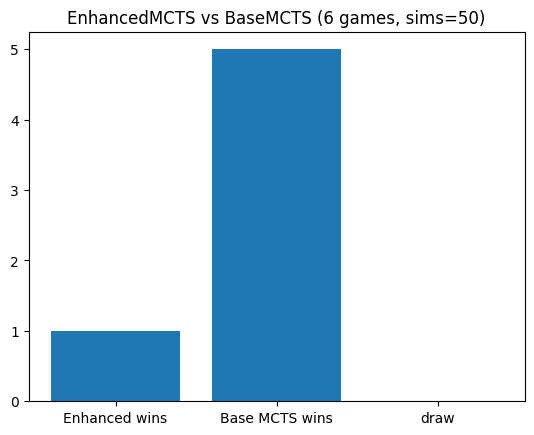

In [ ]:
# 安全版セル：軽量評価 (sims=50, n_games=6)
import time
import matplotlib.pyplot as plt

sims = 50
n_games = 6

# 必要な名前が定義済みかチェック（未定義なら警告して終了）
missing = [name for name in ('MCTSAgent','EnhancedMCTSAgent','evaluate','random_agent') if name not in globals()]
if missing:
    print("エラー: 次の定義が見つかりません:", missing)
    print("→ 対応: まず MCTS/EnhancedMCTS と evaluate, random_agent を定義したセル（クラス定義セル）を上から順に実行してください。")
else:
    print(f"開始: EnhancedMCTS vs MCTS (軽量 sims={sims}, n_games={n_games})")
    t0 = time.time()
    # エージェント作成（軽めの設定）
    base = MCTSAgent(sims_per_move=sims, c_param=1.4)
    enh  = EnhancedMCTSAgent(sims_per_move=sims, c_param=1.2, progressive_widening_k=1.0)

    wins, avg_score, scores = evaluate(enh, base, n_games=n_games)
    t1 = time.time()

    print("=== 結果 ===")
    print("勝敗:", wins)
    print("平均スコア:", avg_score)
    print(f"所要時間: {t1 - t0:.1f} 秒（実環境によって変わります）")

    plt.bar(['Enhanced wins','Base MCTS wins','draw'], [wins['A'], wins['B'], wins['draw']])
    plt.title(f"EnhancedMCTS vs BaseMCTS ({n_games} games, sims={sims})")
    plt.show()
